# TP N°3 — Minería de Datos (TUIA)
**Año:** 2025 • **Materia:** Data Mining • **Integrantes:** Fabrizio Tapia, Sebastian Palacio

**Datasets:**  
- dxWeather.csv (Predicción de estaciones) https://www.kaggle.com/datasets/nikhil7280/weather-type-classification/

**Objetivo:**  
Integrar los conocimientos adquiridos en las unidades 5 y 6 en un problema real asociado a la determinación de la estación del año mediante la medición de atributos característicos

## 1.1 Carga y Exploración Inicial del Dataset

In [44]:
# Librerías básicas para análisis y visualización (sencillo para estudiar)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento, pipelines y validación
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos pedidos en la consigna: SVM y Random Forest
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Métricas básicas para clasificación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Evitar warnings molestos durante el desarrollo
warnings.filterwarnings('ignore')


In [45]:
estaciones = pd.read_csv('dxWeather.csv')


print("INFORMACIÓN GENERAL DEL DATASET \n")
print(f"Dimensiones: {estaciones.shape[0]} filas x {estaciones.shape[1]} columnas")
print(f"\nColumnas: {list(estaciones.columns)}")
print(f"\nTipos de datos:")
print(estaciones.dtypes)

INFORMACIÓN GENERAL DEL DATASET 

Dimensiones: 10090 filas x 8 columnas

Columnas: ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica', 'Localizacion', 'TipoClima', 'Estacion']

Tipos de datos:
Temperatura             int64
Humedad                 int64
VientoVelocidad       float64
Precipitation           int64
PresionAtmosferica    float64
Localizacion           object
TipoClima              object
Estacion               object
dtype: object


In [60]:
estaciones.head()

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica,Localizacion,TipoClima,Estacion
0,39,96,8.5,71,1011.43,Llanura,Nublado,Primavera
1,30,64,7.0,16,1018.72,Montania,Soleado,Primavera
2,38,83,1.5,82,1026.25,Costa,Soleado,Primavera
3,32,55,3.5,26,1010.03,Llanura,Nublado,Verano
4,3,85,6.0,96,984.46,Llanura,Nevado,Invierno


In [46]:
diccionario_variables = {
    'Temperatura': 'Temperatura medida en grados Celsius',
    'Humedad': 'Humedad medida en porcentaje',
    'VientoVelocidad': 'Velocidad del viento medida en km/h',
    'Precipitation': 'Precipitación medida en porcentaje',
    'PresionAtmosferica': 'Presión atmosférica medida en hPa',
    'Localizacion': 'Localización de donde fue tomada la medición',
    'TipoClima': 'Tipo de clima',
    'Estacion': 'Estación meteorológica (target)'
}

print("DICCIONARIO DE VARIABLES \n")

for variable, descripcion in diccionario_variables.items():
    print(f"• {variable:20s} → {descripcion}")

DICCIONARIO DE VARIABLES 

• Temperatura          → Temperatura medida en grados Celsius
• Humedad              → Humedad medida en porcentaje
• VientoVelocidad      → Velocidad del viento medida en km/h
• Precipitation        → Precipitación medida en porcentaje
• PresionAtmosferica   → Presión atmosférica medida en hPa
• Localizacion         → Localización de donde fue tomada la medición
• TipoClima            → Tipo de clima
• Estacion             → Estación meteorológica (target)


In [47]:
estaciones.describe()

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica
count,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000
mean,21.872349,67.195045,9.634936,50.796333,1007.685836
std,16.426722,20.463797,6.795890,32.333798,38.763971
min,-24.000000,20.000000,0.000000,0.000000,800.230000
25%,13.000000,55.000000,5.000000,18.000000,998.570000
50%,23.000000,69.000000,8.500000,53.000000,1010.315000
75%,32.000000,81.000000,13.500000,80.000000,1017.820000
max,109.000000,109.000000,47.500000,109.000000,1199.210000


Desde este punto ya podemos ver algunos valores imposibles como porcentajes superiores a 100% y temperaturas maximas de 109ºC (Mayor que la temperatura a la que hierve el agua)

In [48]:
print("VALORES FALTANTES:\n")

faltantes = estaciones.isnull().sum()

faltantes_pct = (faltantes / len(estaciones)) * 100

df_faltantes = pd.DataFrame({
    'Columna': faltantes.index,
    'Valores Faltantes': faltantes.values,
    'Porcentaje': faltantes_pct.values
})

print(df_faltantes)
print("\n")

print(f"DUPLICADOS: {estaciones.duplicated().sum()}")


VALORES FALTANTES:

              Columna  Valores Faltantes  Porcentaje
0         Temperatura                  0         0.0
1             Humedad                  0         0.0
2     VientoVelocidad                  0         0.0
3       Precipitation                  0         0.0
4  PresionAtmosferica                  0         0.0
5        Localizacion                  0         0.0
6           TipoClima                  0         0.0
7            Estacion                  0         0.0


DUPLICADOS: 0


No encontramos valores faltantes ni duplicados en este dataset

# 1.3 Análisis Exploratorio de Datos (EDA)

## Valores imposibles

En base a lo visto en la descripcion del dataset, consideramos conveniente filtrar directamente los valores imposibles

In [49]:
### Valores imposibles

# Temperaturas Extremadamente Altas e imposibles (mayores 45°C y 100°C)
temp_extrema = estaciones[(estaciones['Temperatura'] > 45)]
conteo_extremo = len(temp_extrema)
print(f"Número de registros con Temperatura mayores a 45°C: {conteo_extremo}")


# Valores imposibles de "Humedad"
humedad_imposible = estaciones[(estaciones['Humedad'] < 0) | (estaciones['Humedad'] > 100)]
conteo_humedad_imposible = len(humedad_imposible)
print(f"Número de registros con Humedad fuera del rango 0-100%: {conteo_humedad_imposible}")


# Valores imposibles de "Precipitación"
precipitacion_imposible = estaciones[(estaciones['Precipitation'] < 0) | (estaciones['Precipitation'] > 100)]
conteo_precipitacion_imposible = len(precipitacion_imposible)
print(f"Número de registros con Precipitación negativa: {conteo_precipitacion_imposible}")


# Valores imposibles de "PresionAtmosferica"
presion_imposible = estaciones[(estaciones['PresionAtmosferica'] < 940) | (estaciones['PresionAtmosferica'] > 1080)]
conteo_presion_imposible = len(presion_imposible)
print(f"Número de registros con Presión Atmosférica fuera del rango 940-1080 hPa: {conteo_presion_imposible}")


print("="*80)

#total
total_imposibles = (conteo_extremo + conteo_humedad_imposible +
                    conteo_precipitacion_imposible + conteo_presion_imposible)
print(f"Número total de registros con valores imposibles: {total_imposibles}")

## Fuente de donde verificamos los valores correctos de presión atmosferica: https://www.netatmo.com/es-es/weather-guide/what-is-the-atmospheric-pressure 

Número de registros con Temperatura mayores a 45°C: 443
Número de registros con Humedad fuera del rango 0-100%: 314
Número de registros con Precipitación negativa: 291
Número de registros con Presión Atmosférica fuera del rango 940-1080 hPa: 670
Número total de registros con valores imposibles: 1718


In [50]:
# Eliminamos los registros con valores imposibles

estaciones = estaciones[
    (estaciones['Temperatura'] <= 45) &
    (estaciones['Humedad'] >= 0) & (estaciones['Humedad'] <= 100) &
    (estaciones['Precipitation'] >= 0) & (estaciones['Precipitation'] <= 100) &
    (estaciones['PresionAtmosferica'] >= 940) & (estaciones['PresionAtmosferica'] <= 1080)
]
print(f"Número de registros después de eliminar valores imposibles: {len(estaciones)}")

Número de registros después de eliminar valores imposibles: 8629


## Variables numéricas

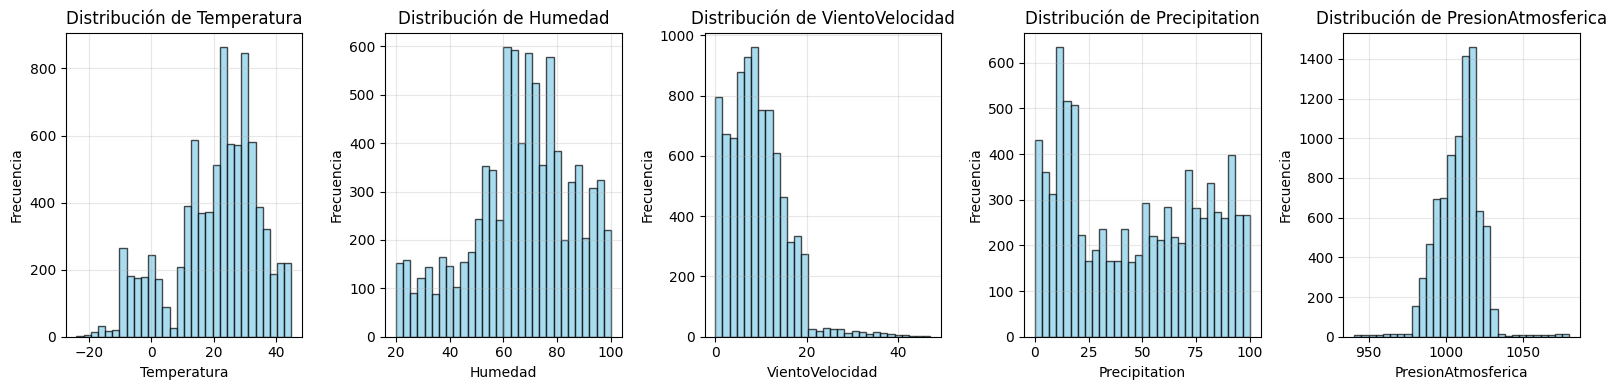

In [57]:
# Distribución de variables numéricas
columnas_numericas = ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica']

fig, axes = plt.subplots(1, 5, figsize=(16, 4))

for i, col in enumerate(columnas_numericas):
    axes[i].hist(estaciones[col], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')
    axes[i].set_title(f'Distribución de {col}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Temperatura:** La distribución es multimodal. Se ve concentraciones alrededor de los 10-15°C y cerca de los 30°C. También hay una concentración de valores en temperaturas bajo cero. Esto sugiere que los datos provienen de poblaciones distintas, probablemente correspondiendo a las diferentes estaciones del año.

**Humedad:** Muestra un sesgo a la izquierda. La mayoría de los valores se concentran en el rango alto (60-100%), con una cola que se extiende hacia valores más bajos.

**VientoVelocidad:** Tiene un fuerte sesgo a la derecha. La gran mayoría de las mediciones son de vientos de baja velocidad (menos de 15 km/h), y hay una larga cola de valores menos frecuentes pero mucho más altos.

**Precipitation:** La distribución es bastante uniforme en todo el rango de 0 a 100.

**PresionAtmosferica:** Distribución semejante a una distribución normal, con un pico centrado ligeramente por encima de 1000 hPa y una disminución simétrica hacia ambos lados.

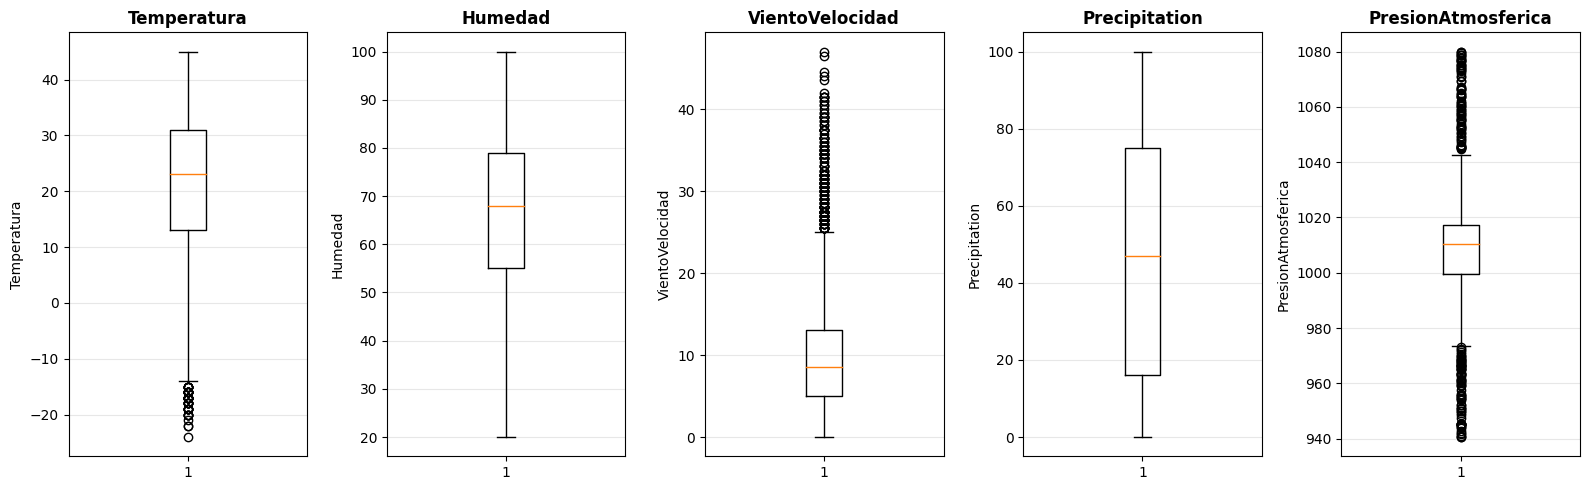

In [52]:
# Boxplot de las variables numéricas
fig, axes = plt.subplots(1, 5, figsize=(16, 5))

for i, col in enumerate(columnas_numericas):
    axes[i].boxplot(estaciones[col], vert=True)
    axes[i].set_ylabel(col)
    axes[i].set_title(f'{col}', fontweight='bold')
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

**Temperatura:** La mediana se sitúa alrededor de los 23°C. La caja principal (rango intercuartílico) va aproximadamente de 13°C a 32°C. Hay numerosos outliers, tanto en valores bajos (hasta -24°C) como altos (superando los 40°C e incluso llegando a valores anómalos por encima de 100°C).


**Humedad:** La mediana está cerca del 70%. Se observan outliers por encima del 100%, lo cual es físicamente imposible y sugiere errores en los datos. También hay algunos valores atípicos en el extremo inferior.


**VientoVelocidad:** La mayoría de las mediciones se concentran en velocidades bajas (la mediana es inferior a 10 km/h), pero hay una gran cantidad de outliers con velocidades altas, llegando hasta casi 50 km/h.


**Precipitation:** La mediana se encuentra sobre el 50%. Al igual que con la Humedad, hay valores atípicos que superan el 100%, lo que es inconsistente si la unidad es un porcentaje y debería ser revisado.


**PresionAtmosferica:** Presenta una gran cantidad de outliers en ambos extremos. Hay valores notablemente bajos (cercanos a 800 hPa) y altos (cercanos a 1200 hPa), que se desvían considerablemente del rango principal.

### Matriz de correlación

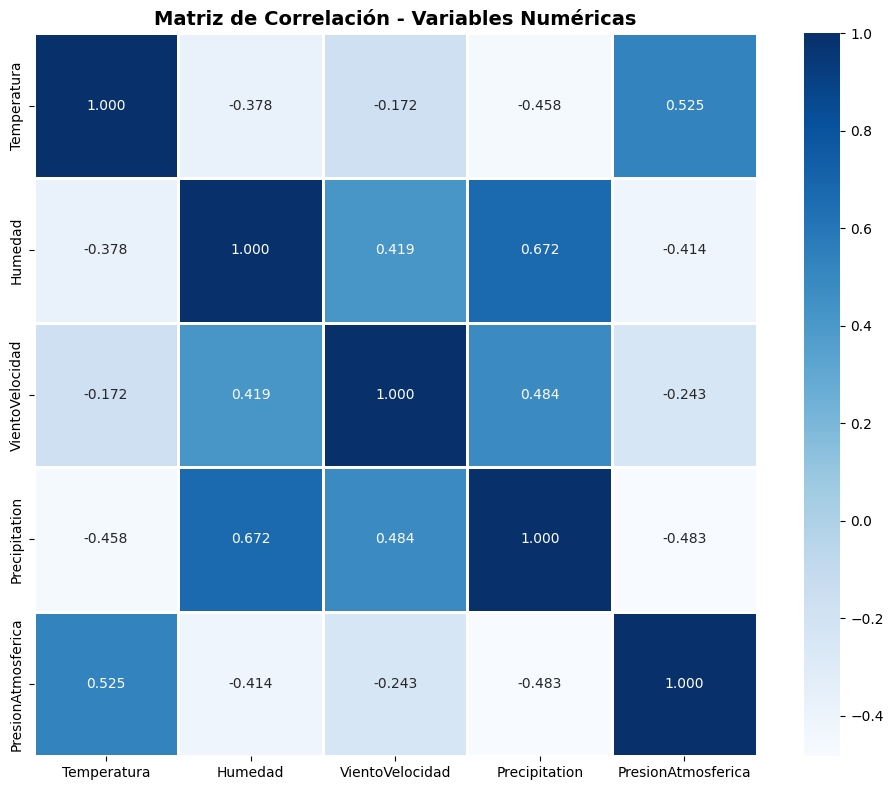

In [53]:
datos_numericos = estaciones.select_dtypes(include=[np.number])
matriz_correlacion = datos_numericos.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, fmt='.3f', cmap='Blues', square=True, linewidths=1)
plt.title('Matriz de Correlación - Variables Numéricas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Correlación positiva fuerte (0.635) entre Humedad y Precipitation, es lógico: A mayor humedad, es más probable que haya precipitación.

Correlaciones positivas moderadas:

VientoVelocidad y Precipitation (0.465): El viento puede transportar nubes y humedad, lo que influye en la precipitación.

Humedad y VientoVelocidad (0.424): Similar al punto anterior, el viento afecta la distribución de la humedad.

Correlación negativa débil (-0.205) entre Temperatura y Precipitation: En algunos climas, las temperaturas más bajas están asociadas con la lluvia o la nieve.
Otras correlaciones son muy débiles (cercanas a cero), lo que indica que esas variables no tienen una relación lineal fuerte entre sí.

## Variables categóricas

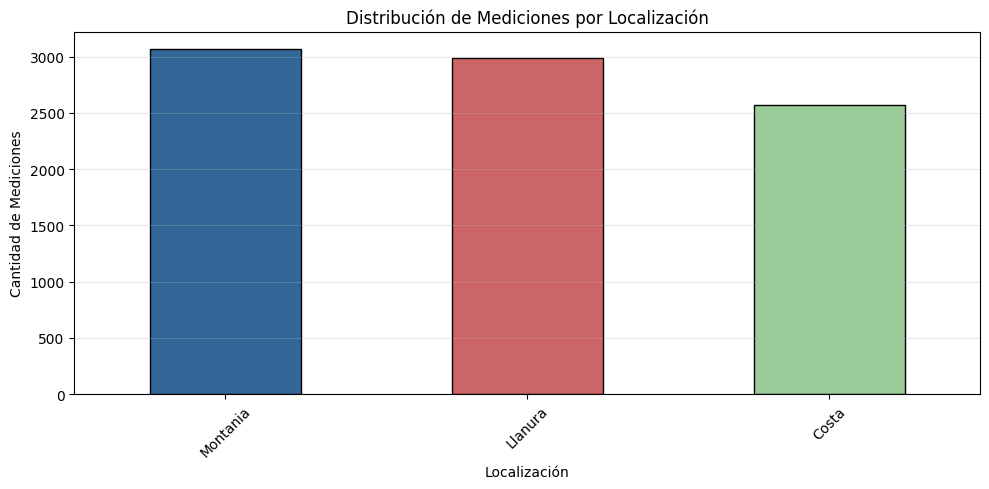


Distribución por Estado:
Localizacion
Montania    3068
Llanura     2986
Costa       2575
Name: count, dtype: int64

Porcentaje por Estado:
Localizacion
Montania    35.55
Llanura     34.60
Costa       29.84
Name: count, dtype: float64


In [54]:
conteo_estados = estaciones['Localizacion'].value_counts()

paleta = ['#336699', '#CC6666', '#99CC99']

plt.figure(figsize=(10, 5))
conteo_estados.plot(kind='bar', color=paleta, edgecolor='black')
plt.xlabel('Localización')
plt.ylabel('Cantidad de Mediciones')
plt.title('Distribución de Mediciones por Localización')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nDistribución por Estado:")
print(conteo_estados)
print(f"\nPorcentaje por Estado:")
print((conteo_estados / len(estaciones) * 100).round(2))

Se puede observar que la distribución de las mediciones entre las localizaciones es relativamente balanceada.

No hay una categoría que domine de forma desproporcionada. Esto significa que el dataset tiene una representación sólida de todas las localizaciones.

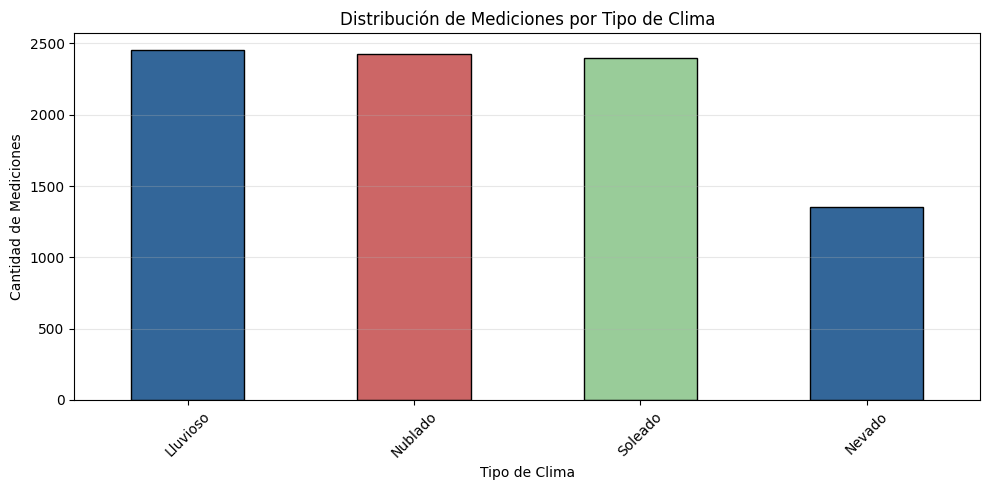


Distribución por Estado:
TipoClima
Lluvioso    2452
Nublado     2426
Soleado     2395
Nevado      1356
Name: count, dtype: int64

Porcentaje por Estado:
TipoClima
Lluvioso    28.42
Nublado     28.11
Soleado     27.76
Nevado      15.71
Name: count, dtype: float64


In [58]:
conteo_estados = estaciones['TipoClima'].value_counts()

paleta = ['#336699', '#CC6666', '#99CC99']

plt.figure(figsize=(10, 5))
conteo_estados.plot(kind='bar', color=paleta, edgecolor='black')
plt.xlabel('Tipo de Clima')
plt.ylabel('Cantidad de Mediciones')
plt.title('Distribución de Mediciones por Tipo de Clima')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nDistribución por Estado:")
print(conteo_estados)
print(f"\nPorcentaje por Estado:")
print((conteo_estados / len(estaciones) * 100).round(2))

Las categorías Soleado, Lluvioso y Nublado están muy bien balanceadas entre sí. Cada una representa alrededor del 28% de los datos.

La categoría Nevado es notablemente menos frecuente, constituyendo solo el 15.9% del total de las mediciones.

**En conclusión:**   Hay un desbalance. La clase Nevado es una clase minoritaria en comparación con las otras tres. Esto es importante tenerlo en cuenta, ya que los modelos de clasificación a veces tienden a favorecer a las clases mayoritarias.

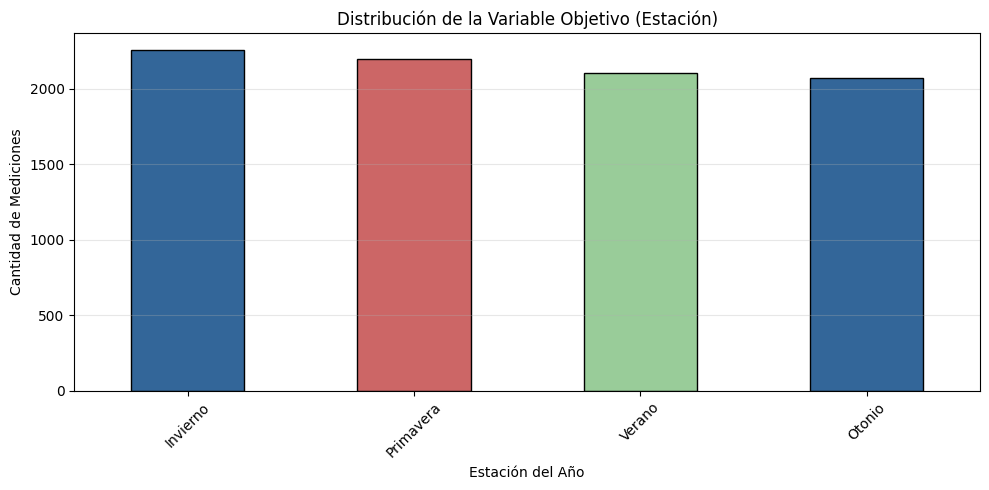


Distribución por Estado:
Estacion
Invierno     2258
Primavera    2196
Verano       2103
Otonio       2072
Name: count, dtype: int64

Porcentaje por Estado:
Estacion
Invierno     26.17
Primavera    25.45
Verano       24.37
Otonio       24.01
Name: count, dtype: float64


In [56]:
conteo_estados = estaciones['Estacion'].value_counts()

paleta = ['#336699', '#CC6666', '#99CC99']

plt.figure(figsize=(10, 5))
conteo_estados.plot(kind='bar', color=paleta, edgecolor='black')
plt.xlabel('Estación del Año')
plt.ylabel('Cantidad de Mediciones')
plt.title('Distribución de la Variable Objetivo (Estación)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nDistribución por Estado:")
print(conteo_estados)
print(f"\nPorcentaje por Estado:")
print((conteo_estados / len(estaciones) * 100).round(2))

Las clases estan relativamente balanceadas.

El modelo tendrá la misma cantidad de ejemplos para aprender de cada estación.

No se necesitan técnicas especiales para tratar con datos desbalanceados.

### Falta conclusion parcial

### Cositas para agregar

Scatterplot con hue: Graficar la relación entre dos variables numéricas, pero coloreando los puntos según una categoría.

por ejemplo un gráfico de Temperatura vs. Humedad, con los puntos coloreados por Estacion, podría mostrar "clusters" o agrupaciones claras. 
Por ejemplo, puntos de Verano podrían agruparse en la zona de alta temperatura y alta humedad, mientras que los de Invierno estarían en la zona de baja temperatura.


Ejemplo: sns.scatterplot(x='Temperatura', y='Humedad', hue='Estacion', data=estaciones)

---
pairplot para ver matrixz de gragicos de variables numericas y probar tambien con HUE estacion

# Preprocesamiento

convertir variables cat en  onehot, normalizar?

por ahora no eliminamos outliers y probamos modelos hasta obtener metricas

split

ColumnTransformer dentro de pipeline? con onehot y stndrscaler


**preparacion para:**

Máquinas de Vectores de Soporte (SVM): Se pide explícitamente usar SVM con kernel lineal y con kernel gaussiano (RBF). (ESCALAR)

Random Forest: También se solicita usar este modelo de ensamble (NO ESCALAR)

